## Model Training - Species Classification
Reads dataframe and uses Resnet 50 to perform species classification on Dangermont data.

### 1. Preprocessing

In [160]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
import cv2
import os

In [161]:
# get and preprocess image for given image name
def process_image(img_name, img_path, new_shape):
    # get and preprocess
    path = f"{img_path}/{img_name}.jpg"
    image = cv2.imread(path)
    image = cv2.resize(image, new_shape)
    return image

def process_df(df_path, img_path, new_shape):
    # read df from df path
    df = pd.read_csv(df_path, index_col=False)
    df = df.drop(columns=["Unnamed: 0"])
    
    # get processed image
    df["image"] = df["img_name"].apply(lambda x: process_image(x, img_path, new_shape))
    return df

In [162]:
# remove classes with less than or equal to n observations
def remove_classes(df, n):
    df_group = df[["img_name", "common_name"]].groupby("common_name", as_index=False).count()
    selected_species = list(df_group[df_group["img_name"] > n]["common_name"])
    
    return df[df["common_name"].isin(selected_species)]

In [163]:
# organize data in necessary format for ResNet
def format_data(df, path):
    for img, img_name, cname in zip(df["image"].values, df["img_name"].values, df["common_name"].values):
        full_path = f"{path}/{cname}/"
        
        # one folder per label
        if not os.path.isdir(full_path):
            os.makedirs(full_path)
        full_name = f"{full_path}/{img_name}.jpg"
    
        # write file if it doesn't exist already
        if not os.path.isfile(full_name):
            cv2.imwrite(full_name, img)

In [5]:
df_path = "df.csv" 
img_path = "images-bboxes/jldp"

img_shape = (224, 224)
df = process_df(df_path, img_path, img_shape)
df = remove_classes(df, 5)

In [164]:
# # TODO: delete cell
idiaz_path = "/Users/isidoradiaz/Documents"
df_path = f"{idiaz_path}/df_aws.csv" 
img_path = f"{idiaz_path}/images-bboxes/jldp"

img_shape = (224, 224)
df = process_df(df_path, img_path, img_shape)
df = remove_classes(df, 5)

In [6]:
path = "tf-dataset/jldp"
format_data(df, path)

In [165]:
# TODO: delete cell
path = f"{idiaz_path}/tf-dataset/jldp"
format_data(df, path)# df

### 2. Exploratory Data Analysis

In [166]:
# 33 classes
# 29 classes after removing those with <= 5 observations
# marked class imbalance!
df[["common_name", "img_name"]].groupby("common_name", as_index=False).count().\
    sort_values(by="img_name", ascending=False)

common_name  img_name
7                     Coyote      4207
26                 Wild Boar      2178
17                 Mule Deer       852
8            Domestic Cattle       595
25      Western fence lizard       475
24              Western Gull       158
4            California Gull       151
12          Great Blue Heron       125
21            Turkey Vulture       113
16                   Mallard       101
6               Common Raven        60
0        American Black Bear        35
23     Western Gray Squirrel        26
13               Great Egret        24
20             Striped Skunk        21
11  Double-crested Cormorant        15
18               Snowy Egret        15
10              Domestic Pig        14
1             American Robin        13
9               Domestic Dog        13
2         Brandt's Cormorant        10
14          Great Horned Owl         8
15                  Grey Fox         8
5       California Scrub-Jay         8
22          Virginia Opossum         7
19              Snowy Plover         6
3                  Brown Rat         6

In [9]:
num_classes = len(df["common_name"].unique())
print(f"There are {num_classes} classes")

There are 27 classes


### 3. Modeling

#### Resnet 50

In [167]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow import keras as K
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model, load_model
from keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Flatten, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [168]:
def resnet_model(input_shape, n_trainable, num_classes, dropout_rate=0.5):
    # Load the pre-trained ResNet50 model
    base_model = ResNet50(weights="imagenet", include_top=False, input_shape=input_shape)

    # Freeze the first n - n_trainable layers
    for layer in base_model.layers[:-n_trainable]:
        layer.trainable = False

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(dropout_rate)(x)  # Adding dropout for regularization
    output_tensor = Dense(num_classes, activation="softmax")(x)

    model = Model(base_model.input, outputs=output_tensor)
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

    return model

In [169]:
def train_val_test_data(path, target_size, batch_size, test_size=0.1, validation_size=0.2):
    # List all class directories
    classes = sorted((f for f in os.listdir(path) if not f.startswith(".")), key=str.lower)

    # Create empty lists to store file paths
    train_files, test_files = [], []

    # Iterate through each class
    for class_name in classes:
        class_path = os.path.join(path, class_name)
        images = os.listdir(class_path)

        # Split images into train and test
        train, test = train_test_split(images, test_size=test_size, stratify=[class_name]*len(images), random_state=42)

        # Append file paths and class labels to respective lists
        train_files.extend([(os.path.join(class_path, img), class_name) for img in train])
        test_files.extend([(os.path.join(class_path, img), class_name) for img in test])

    # Further split training set into training and validation
    train_files, validation_files = train_test_split(train_files, test_size=validation_size, stratify=[item[1] for item in train_files], random_state=42)
    
    # Create DataFrames
    train_df = pd.DataFrame(train_files, columns=['filepath', 'class'])
    validation_df = pd.DataFrame(validation_files, columns=['filepath', 'class'])
    test_df = pd.DataFrame(test_files, columns=['filepath', 'class'])

    # Create ImageDataGenerators
    datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input
    )

    train_generator = datagen.flow_from_dataframe(
        train_df,
        x_col='filepath',
        y_col='class',
        target_size=target_size,
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=True  # Shuffle the training data
    )

    validation_generator = datagen.flow_from_dataframe(
        validation_df,
        x_col='filepath',
        y_col='class',
        target_size=target_size,
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=False  # Don't shuffle the val data
    )

    test_generator = datagen.flow_from_dataframe(
        test_df,
        x_col='filepath',
        y_col='class',
        target_size=target_size,
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=False  # Don't shuffle the test data
    )

    return train_generator, validation_generator, test_generator


In [170]:
batch_size = 32
dim = 224
input_shape = (dim, dim, 3)
target_size = (dim, dim)

# train and test data
train_generator, validation_generator, test_generator = train_val_test_data(path, target_size, batch_size)

Found 6645 validated image filenames belonging to 27 classes.
Found 1662 validated image filenames belonging to 27 classes.
Found 937 validated image filenames belonging to 27 classes.


In [171]:
trainable_layers = 30

# compiled model
model = resnet_model(input_shape, trainable_layers, num_classes)

In [ ]:
# Maintain class imbalance
train_class_weight = pd.Series(train_generator.classes).value_counts().to_dict()

# fitting model
history = model.fit(
    train_generator,
    validation_data = validation_generator,
    batch_size=batch_size, 
    epochs = 10, # increase to 8?
    verbose = True,
    class_weight = train_class_weight
)

Epoch 1/10
251/251 [==============================] - 925s 4s/step - loss: 699.4156 - accuracy: 0.8134 - val_loss: 0.4288 - val_accuracy: 0.9057
Epoch 2/10
248/251 [============================>.] - ETA: 10s - loss: 109.6477 - accuracy: 0.9177

In [ ]:
# save model
path = "tf-dataset"
model.save(f"{path}/resnet50_jldp.keras")

structure_path = f"{path}/model01.json"
weights_path = f"{path}/model01.h5"

# save structure
with open(structure_path, "w") as json_file:
    json_file.write(model.to_json())
    
# save weights
model.save_weights(weights_path)

In [16]:
# # TODO: delete cell
# path = "/Users/isidoradiaz/Documents/tf-dataset"

# structure_path = f"{path}/model01.json"
# weights_path = f"{path}/model01.h5"

In [172]:
LOAD = True
COMPLETE_MODEL = False
if LOAD and COMPLETE_MODEL:
    # load previously trained model
    model = load_model(f"{path}/resnet50_jldp.keras")
elif LOAD:
    # load model structure
    with open(structure_path, "r") as json_file:
        model = tf.keras.models.model_from_json(json_file.read())
    # load weights
    model.load_weights(weights_path)

### 4. Predictions

In [173]:
# predictions for test set
def test_predictions(test_generator, labels):
    test_predictions = model.predict(test_generator)
    pred_indices = np.argmax(test_predictions, axis=1)
    
    pred_labels = pd.Series([labels[i] for i in pred_indices])
    return pred_labels

def test_labels(test_generator, labels):
    actual_labels = pd.Series([labels[i] for i in test_generator.classes])
    return actual_labels

labels = list(test_generator.class_indices.keys())
preds = test_predictions(test_generator, labels)
actuals = test_labels(test_generator, labels)

30/30 [==============================] - 23s 740ms/step


In [174]:
# calculate test set accuracy
accuracy = np.mean(actuals == preds)
print("Accuracy on test set: {:.2%}".format(accuracy))

Accuracy on test set: 93.92%


In [20]:
# calculate confusion matrix
conf_matrix = confusion_matrix(actuals, preds)

# stats
correct_n = np.diagonal(conf_matrix)
total_n = np.sum(conf_matrix, axis = 1)

test_stats = pd.DataFrame({
        "Species": labels,
        "Count": total_n,
        "Accuracy": correct_n / total_n})

In [21]:
test_stats.sort_values(by="Accuracy")

Species  Count  Accuracy
0        American Black Bear      4  0.000000
23     Western Gray Squirrel      3  0.000000
22          Virginia Opossum      1  0.000000
20             Striped Skunk      3  0.000000
19              Snowy Plover      1  0.000000
18               Snowy Egret      2  0.000000
15                  Grey Fox      1  0.000000
14          Great Horned Owl      1  0.000000
11  Double-crested Cormorant      2  0.000000
10              Domestic Pig      2  0.000000
13               Great Egret      3  0.000000
6               Common Raven      6  0.000000
5       California Scrub-Jay      1  0.000000
3                  Brown Rat      1  0.000000
2         Brandt's Cormorant      1  0.000000
1             American Robin      2  0.000000
9               Domestic Dog      2  0.000000
4            California Gull     16  0.875000
21            Turkey Vulture     12  0.916667
17                 Mule Deer     86  0.941860
8            Domestic Cattle     60  0.966667
26                 Wild Boar    218  0.972477
7                     Coyote    421  0.988124
12          Great Blue Heron     13  1.000000
25      Western fence lizard     48  1.000000
16                   Mallard     11  1.000000
24              Western Gull     16  1.000000

In [153]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap


def plot_test_stats(df, title, annotation, palette="rocket"):
    plot_subset = df.sort_values(by="Count", ascending=False)

    plot_subset.loc[:, 'Accuracy'] = np.round(plot_subset['Accuracy'].astype(float)*100, 1)

    # Create a custom colormap
    custom_palette = sns.color_palette(palette, len(plot_subset['Species']))
    custom_colormap = ListedColormap(custom_palette)

    # Use pivot to reshape the DataFrame
    plot_data = plot_subset.pivot(index='Accuracy', columns='Species', values='Count')

    # Sort columns by sum in descending order
    plot_data = plot_data[plot_data.sum().sort_values(ascending=False).index]

    # Plot the stacked bar chart
    plot_data.plot(kind='bar', stacked=True, colormap=custom_colormap, figsize=(12, 6))

    # Format x-axis ticks
    plt.xticks(rotation=0) 

    # Add labels and title
    plt.xlabel('Accuracy on Test')
    plt.ylabel('Image Count')
    plt.title(title)

    # Show legend
    plt.legend(title='Species', frameon=False,  reverse=True, loc=6, bbox_to_anchor=(1.05, 0.5),)

    # Add text annotation
    plt.figtext(0.1, 0.01, annotation, wrap=True, horizontalalignment='left', fontsize=10)

    # Show the plot
    plt.show()

high_accuracy = test_stats[test_stats['Accuracy'] > 0.5]
annotation="*High Accuracy: > 50%"
plot_test_stats(high_accuracy, title='High Accuracy Distribution by Species', annotation=annotation, palette="Paired")




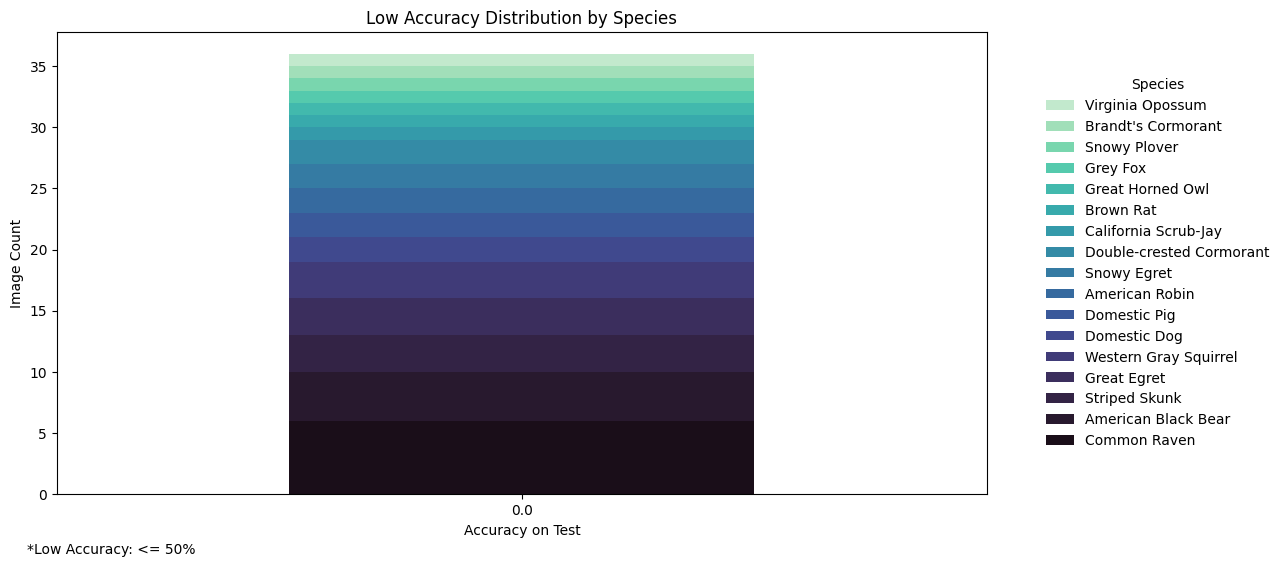

In [154]:
low_accuracy = test_stats[test_stats['Accuracy'] <= 0.5]
annotation="*Low Accuracy: <= 50%"
plot_test_stats(low_accuracy, title='Low Accuracy Distribution by Species', annotation=annotation, palette="mako")

In [57]:
test_class_weight = pd.Series(test_generator.classes).value_counts().to_dict()

top_classes = sorted(test_class_weight.items(), key = lambda x: -x[1])[:10]
class_index, class_count = list(zip(*top_classes))

In [73]:
top_classes = sorted(test_class_weight.items(), key = lambda x: -x[1])[:10]
class_index, class_count = list(zip(*top_classes))
class_label = [test_labels[i] for i in class_index]

In [183]:
test_class_weights = list(pd.Series(test_generator.classes).value_counts().to_dict().items())
test_indices, test_counts = list(zip(*test_class_weights))


# labels_05 = [labels[i] for i in class_index]

In [208]:
def conf_matrix_subset(i, j, conf_matrix, weights, indices, counts, labels):
    indices = list(indices)[i:j]
    cf = conf_matrix[indices][:, indices]
    labels = [labels[i] for i in indices]
    return cf, labels

<Axes: >

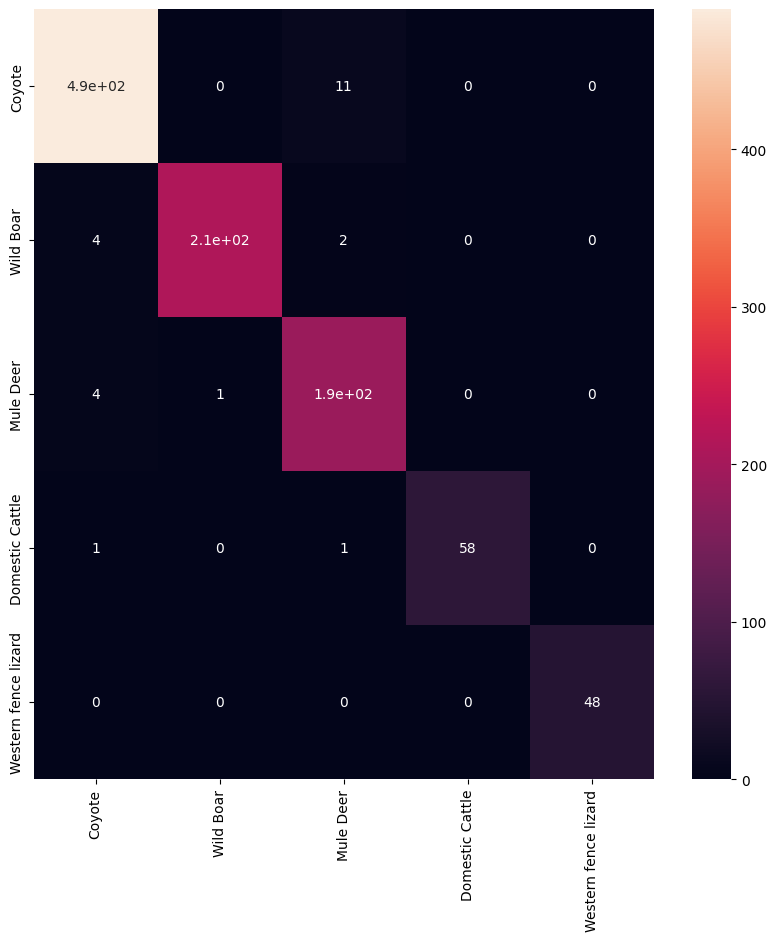

In [220]:
cf, lab = conf_matrix_subset(0, 5, conf_matrix, test_class_weights, test_indices, test_counts, labels)

fig, ax = plt.subplots(figsize=(10,10))

cf_str = np.vectorize(lambda x: f"{x:.0f}")(cf)

sns.heatmap(cf, ax = ax, annot = True, xticklabels = lab, yticklabels = lab)

In [217]:
cf

array([[489,   0,  11,   0,   0],
       [  4, 212,   2,   0,   0],
       [  4,   1, 189,   0,   0],
       [  1,   0,   1,  58,   0],
       [  0,   0,   0,   0,  48]], dtype=int64)

In [86]:
fig, ax = plt.subplots(figsize=(20,18))
sns.heatmap(conf_matrix, ax = ax, annot = True, xticklabels = class_label, yticklabels = class_label,)
ax.set_xlabel("Predicted Species")
ax.set_ylabel("Actual Species");

In [291]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [176]:
test_df = pd.DataFrame()
test_df['filename'] = test_generator.filenames
test_df['actual'] = actuals
test_df['predicted'] = preds
test_df.loc[test_df['actual']==test_df['predicted'],'Same'] = True
test_df.loc[test_df['actual']!=test_df['predicted'],'Same'] = False

test_df.to_csv(f'{path}/test_results.csv')

/var/folders/2l/bmpcb3q56fn5gfp47jzgk5xm0000gn/T/ipykernel_20727/878125528.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  test_df.loc[test_df['actual']==test_df['predicted'],'Same'] = True


In [177]:
test_df.head()

filename               actual  \
0  /Users/isidoradiaz/Documents/tf-dataset/jldp/A...  American Black Bear   
1  /Users/isidoradiaz/Documents/tf-dataset/jldp/A...  American Black Bear   
2  /Users/isidoradiaz/Documents/tf-dataset/jldp/A...  American Black Bear   
3  /Users/isidoradiaz/Documents/tf-dataset/jldp/A...  American Black Bear   
4  /Users/isidoradiaz/Documents/tf-dataset/jldp/A...       American Robin   

   predicted   Same  
0  Wild Boar  False  
1  Wild Boar  False  
2  Wild Boar  False  
3  Wild Boar  False  
4  Mule Deer  False

# Gradient-weighted Class Activation Mapping (Grad-CAM)

Grad-CAM, or Gradient-weighted Class Activation Mapping, is a technique used in the field of computer vision to understand and interpret the decisions made by convolutional neural networks (CNNs) during image classification tasks. Grad-CAM provides insight into which regions of an input image the model focuses on when predicting a specific class. The method operates by calculating the gradient of the predicted class with respect to the feature maps of the last convolutional layer in the neural network. These gradients are then used to produce a weighted combination of the feature maps, creating a heatmap that highlights the important regions for the model's decision, that can be visualized through the overlay of the heatmap onto the original image.

These visualizations play a crucial role in enhancing models by providing interpretability. They help identify whether the model is focusing on the correct features, guiding the debugging process, and aiding in refining the model's architecture. By understanding where the model directs its attention, we can make informed adjustments to improve the model's accuracy and efficiency.

However, it's important to note a caveat: Grad-CAM visualizations can be sensitive to small changes in input data or model parameters, which might result in fluctuations in the highlighted regions. While this instability could be a concern in certain scenarios, the nature of camera trap images typically involves consistent environmental settings and static backgrounds. Since our primary interest lies in understanding the model's attention within these stable and predefined conditions, the minor fluctuations in Grad-CAM due to instability may not significantly impact the overall interpretability and utility of the visualizations for our specific application. Therefore, while acknowledging the caveat, we can reasonably prioritize the valuable insights provided by Grad-CAM for the purpose of model refinement in this context.

In [270]:
img_size = 224
def readImage(path):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    n_idx = np.min([15, len(temp_df)])
    rand_idx = temp_df.sample(n=n_idx, random_state=42).index
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(n_idx):
        i = rand_idx[i]
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
        image = readImage(f"{temp_df.filename[i]}")
        plt.imshow(image)
        plt.title(f'A: {temp_df.actual[i]} P: {temp_df.predicted[i]}')

### Correctly Classified Randomly Sampled Images

In [271]:
display_images(test_df[test_df.Same == True])

### Misclassified Randomly Sampled Images

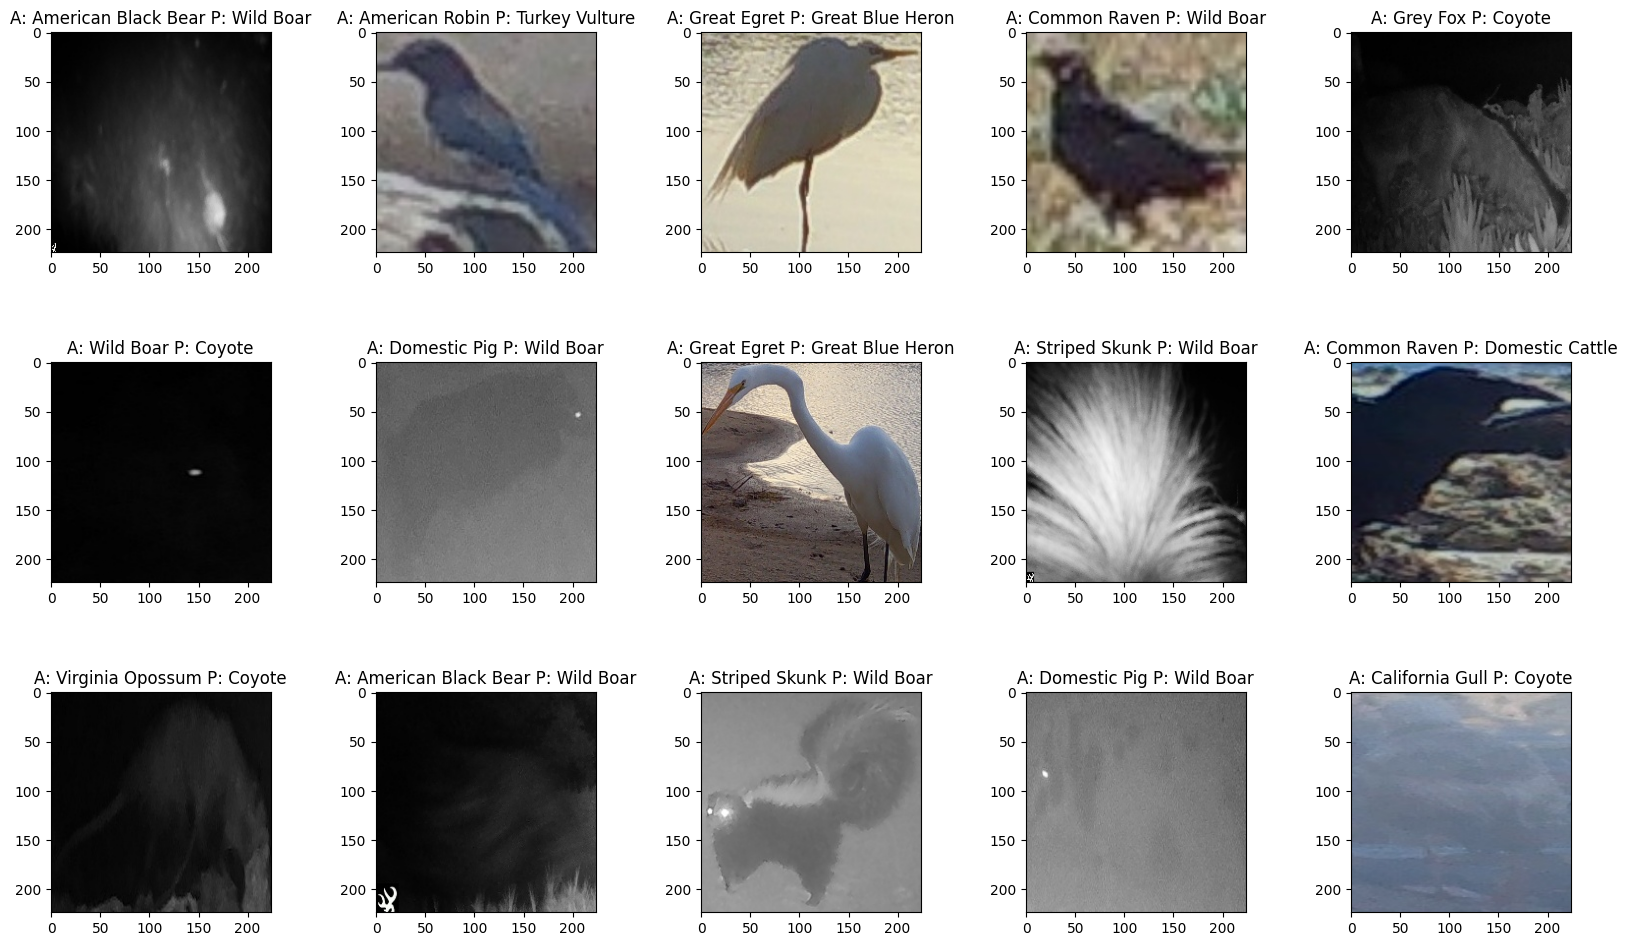

In [221]:
display_images(test_df[test_df.Same == False])

In [241]:
def make_gradcam_heatmap(img_array, model, pred_index=None):
    # Identify the last convolutional layer
    last_conv_layer_name = [layer.name for layer in model.layers if isinstance(layer, tf.keras.layers.Conv2D)][-1]
    
    grad_model = Model(inputs=model.inputs, outputs=[model.get_layer(last_conv_layer_name).output, model.output])

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy(), preds

In [242]:
def gradCAMImage(image):
    img = load_img(image, target_size=(224, 224))
    img_array = img_to_array(img)
    
    # Preprocess the image using ResNet preprocessing
    img_array = preprocess_input(img_array)
    
    img_array = np.expand_dims(img_array, axis=0)
    heatmap, preds = make_gradcam_heatmap(img_array, model)

    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img_array.shape[2], img_array.shape[1]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.8 + img_array[0]
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    return superimposed_img

In [272]:
def gradcam_of_images(correct_class, filter_class=None):
    grad_images = []
    title = []
    temp_df = test_df[test_df['Same']==correct_class]
    if filter_class is not None:
        temp_df = temp_df[temp_df['actual']==filter_class]
    n_idx = np.min([15, len(temp_df)])
    temp_df = temp_df.reset_index(drop=True)
    rand_idx = temp_df.sample(n=n_idx, random_state=42).index
    for i in range(n_idx):
        i = rand_idx[i]
        image = temp_df.filename[i]
        grad_image = gradCAMImage(image)
        grad_images.append(grad_image)
        title.append(f"A: {temp_df.actual[i]} P: {temp_df.predicted[i]}")

    return grad_images, title

In [262]:
correctly_classified, c_titles = gradcam_of_images(correct_class=True)
misclassified, m_titles = gradcam_of_images(correct_class=False)


/var/folders/2l/bmpcb3q56fn5gfp47jzgk5xm0000gn/T/ipykernel_20727/3953245750.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


In [263]:
def display_heatmaps(classified_images,titles):
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(np.min([15, len(classified_images)])):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
        plt.imshow(classified_images[i])
        plt.title(titles[i])
    plt.show()

## Grad-CAM Visualizations

### Correctly Classified

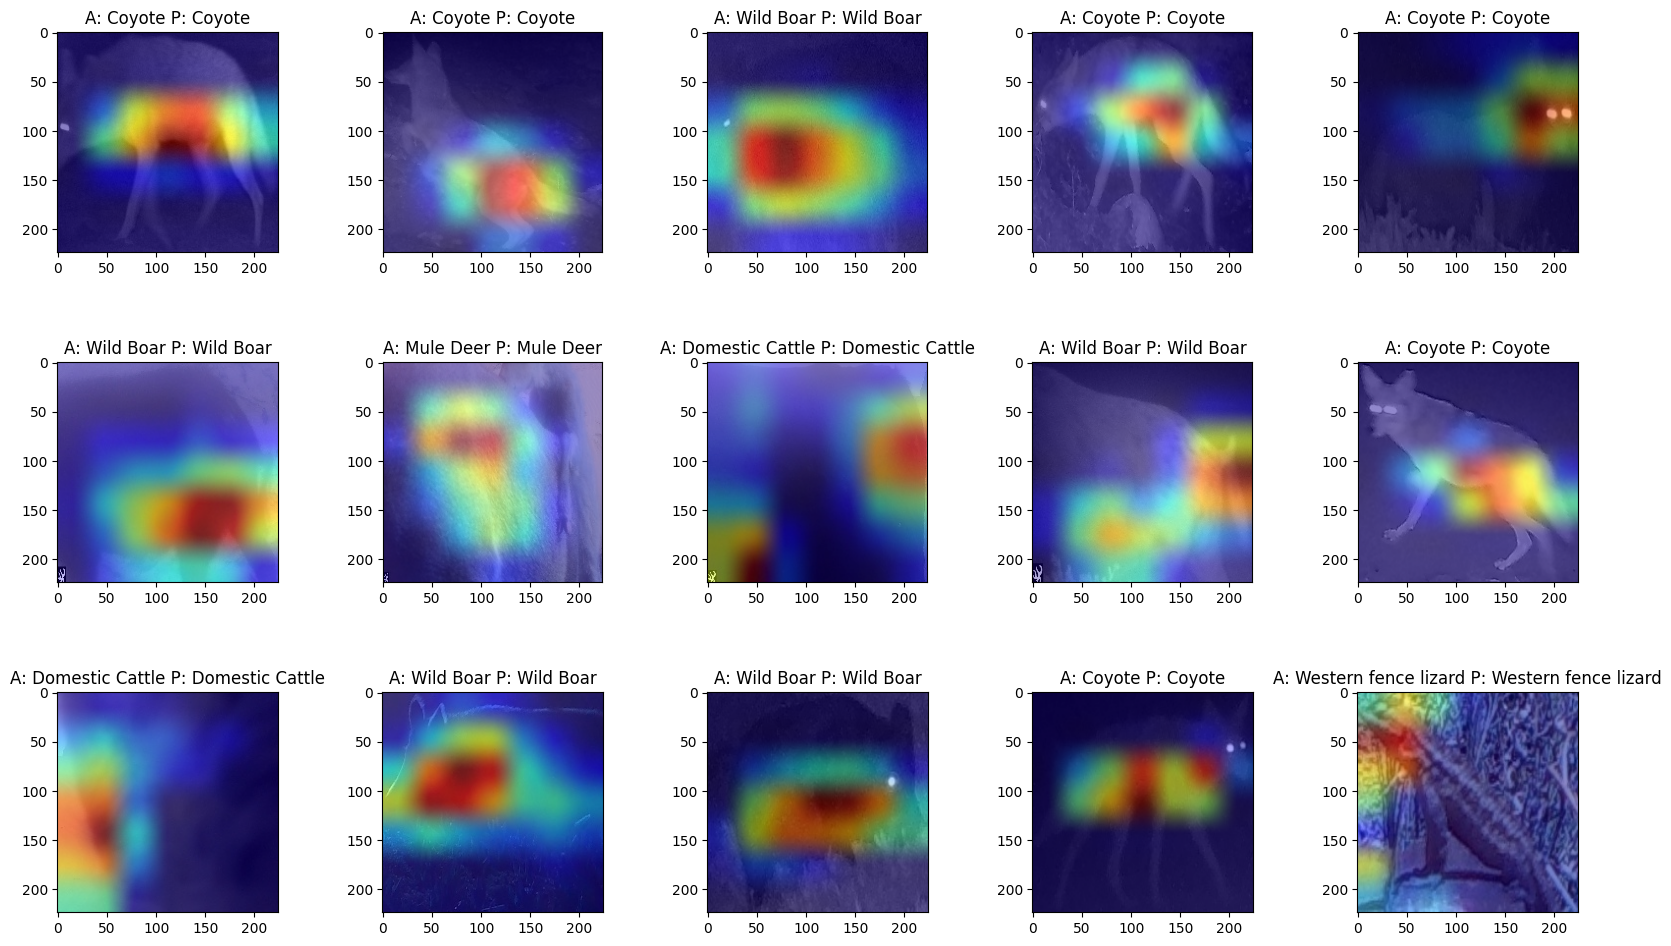

In [264]:
display_heatmaps(correctly_classified,c_titles)

### Misclassified

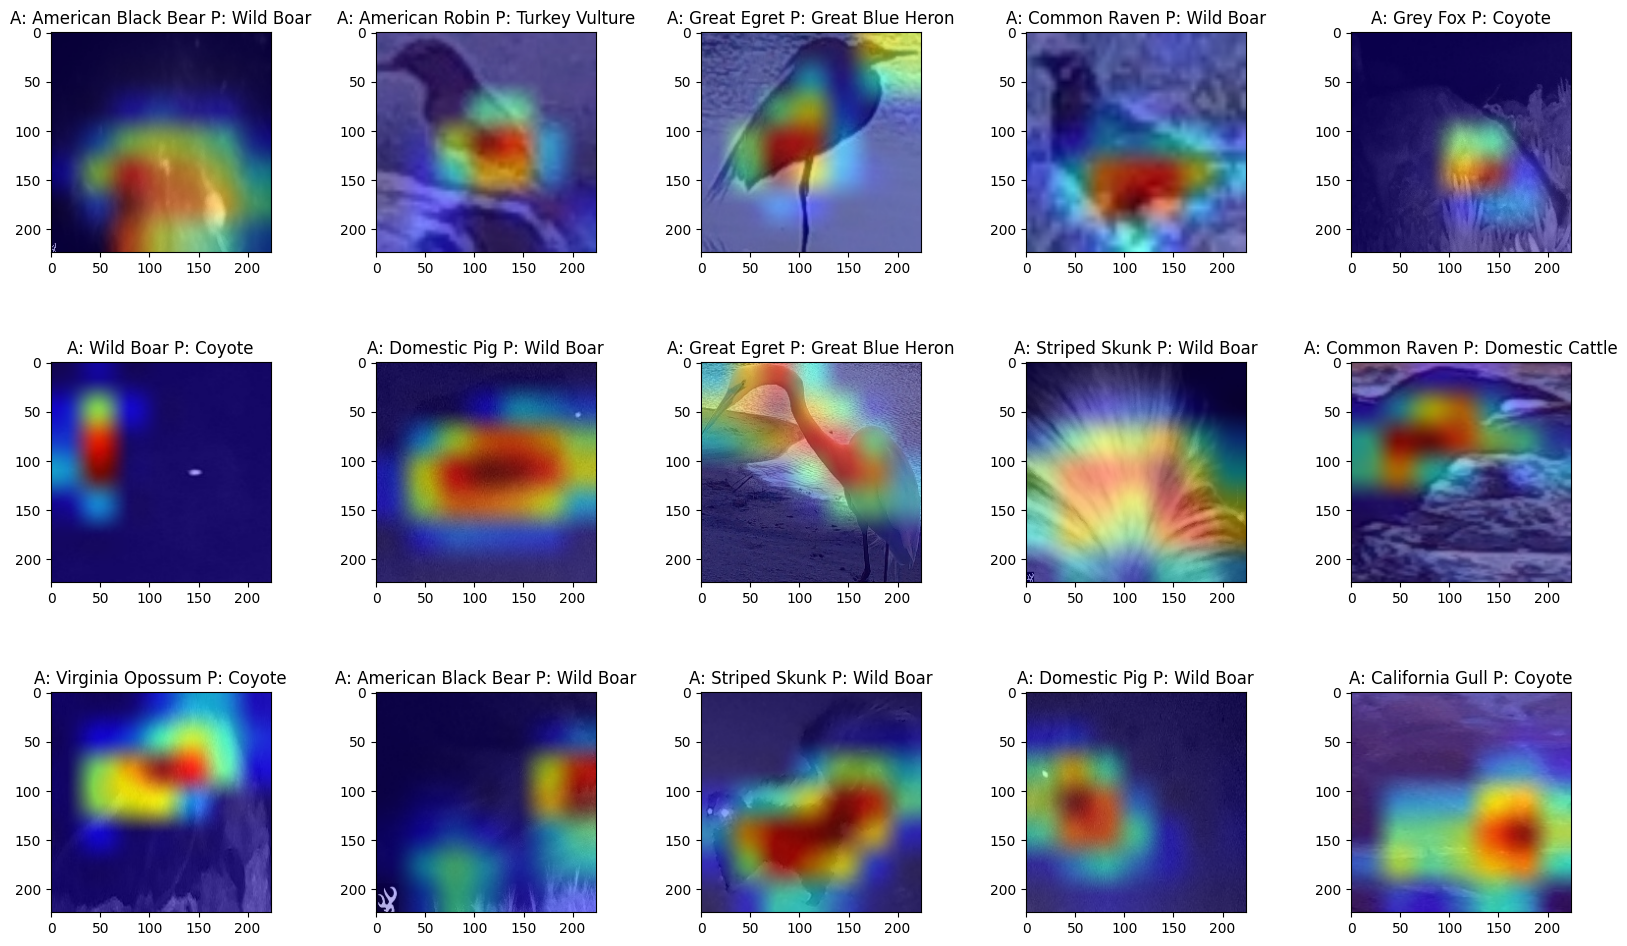

In [265]:
display_heatmaps(misclassified,m_titles)

# Interpreting California Gull Classifications through the Grad-CAM Lens

This section explores Grad-CAM visualizations for the California Gull class, the only category exhibiting accuracy below 90% despite a training dataset of more than 10 images. As shown in the following visualizations,  we find evidence of an over-reliance on background elements rather than key features of the bird. 

### Correctly classified

In [273]:
correctly_classified, c_titles = gradcam_of_images(correct_class=True, filter_class='California Gull')
misclassified, m_titles = gradcam_of_images(correct_class=False, filter_class='California Gull')

/var/folders/2l/bmpcb3q56fn5gfp47jzgk5xm0000gn/T/ipykernel_20727/3953245750.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


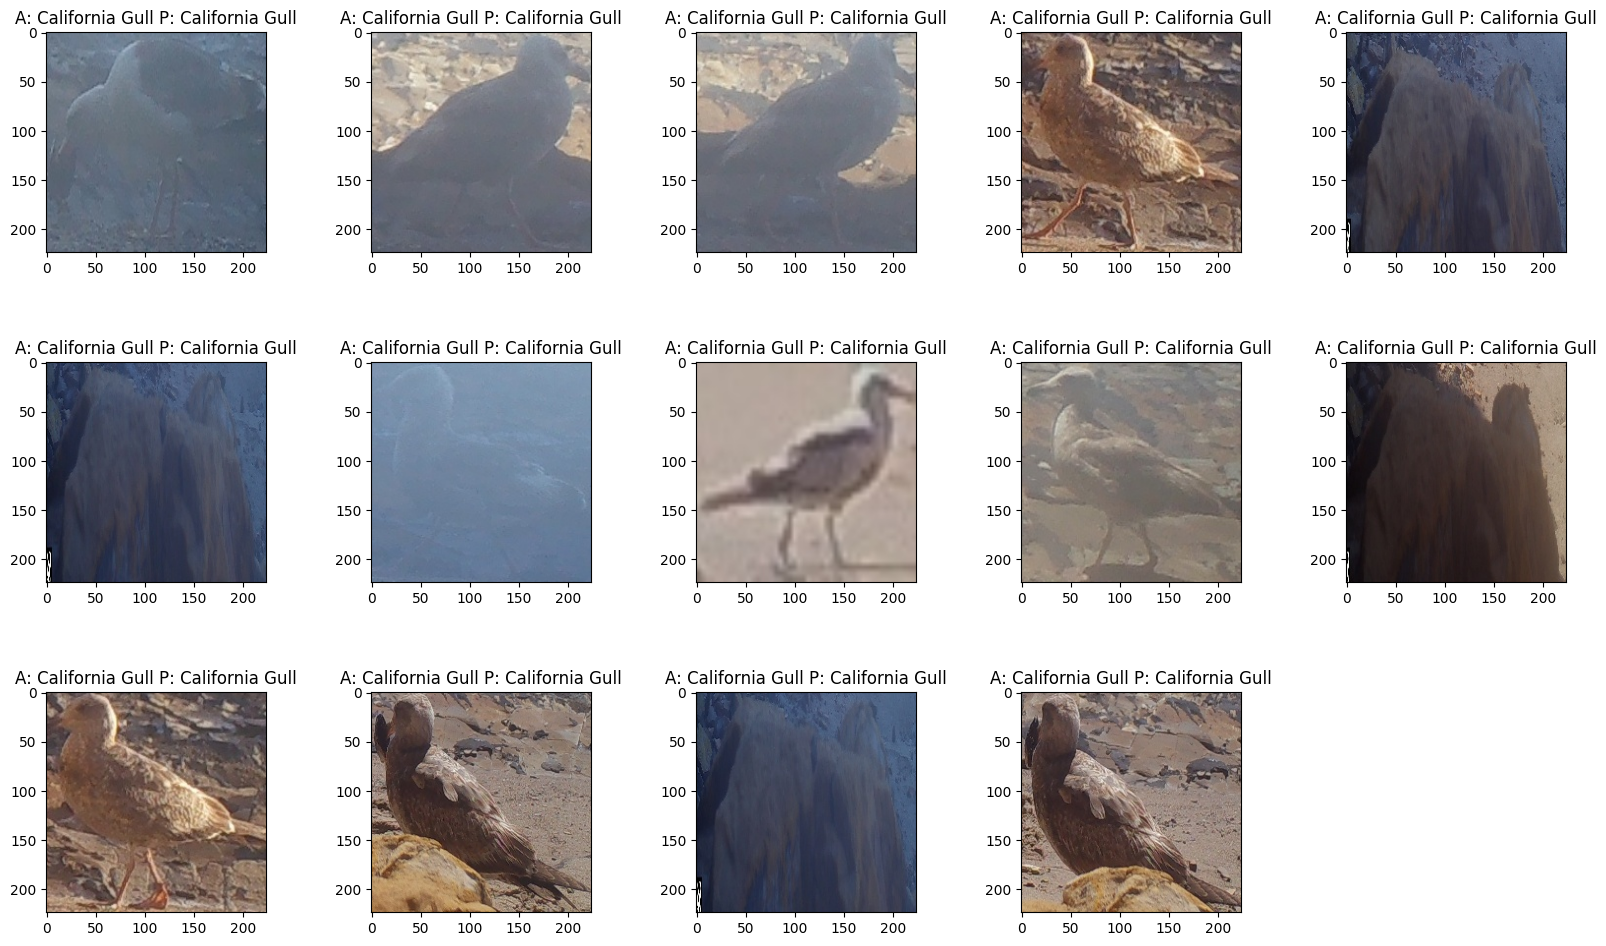

In [274]:
display_images(test_df[(test_df.Same == True) & (test_df.actual == 'California Gull')])

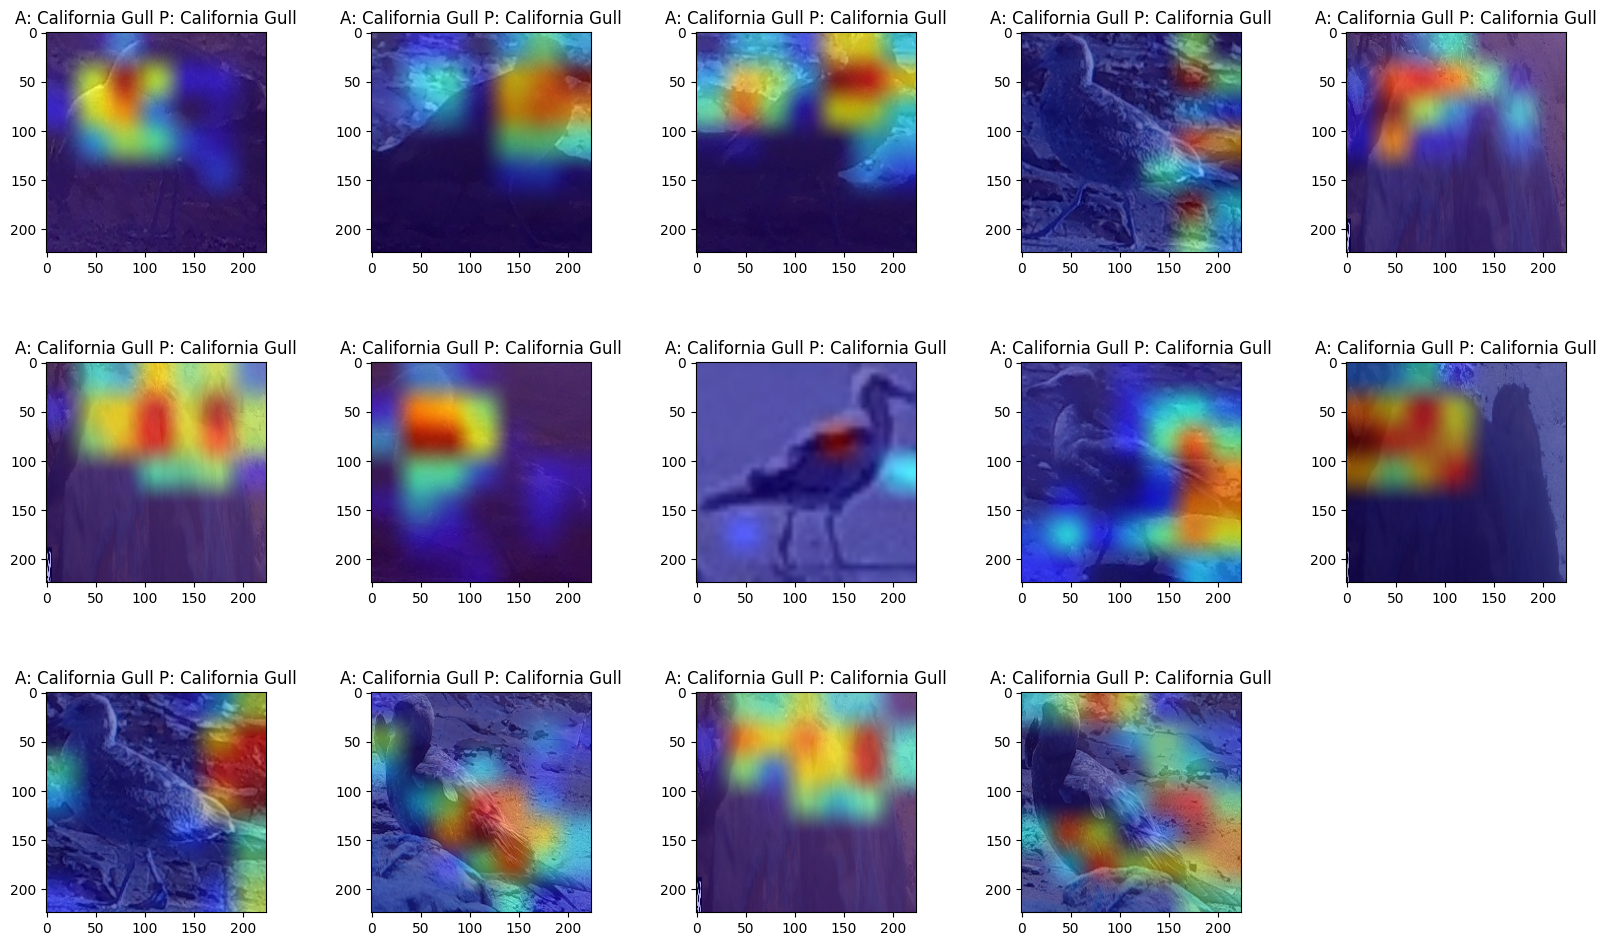

In [275]:
display_heatmaps(correctly_classified,c_titles)

### Misclassified

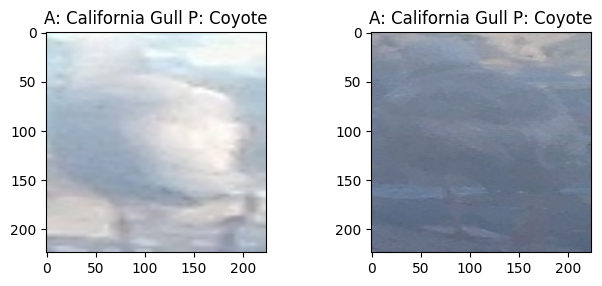

In [276]:
display_images(test_df[(test_df.Same == False) & (test_df.actual == 'California Gull')])

In [277]:
display_heatmaps(misclassified,m_titles)

As expected, we've noticed a significant pattern: the model tends to focus more on the background than on the bird itself. To address this, one potential solution is to train the model on images where the background has been removed, or narrowing the bounding boxes before cropping. Another option is to create synthetic images featuring the same species on different backgrounds, which would additionally increase training sample size, providing an alternative approach for evaluation and improvement.